In [3]:
from interaction_inference.simulation import gillespie_birth_death, gillespie_telegraph
from interaction_inference.optimization import Optimization
from interaction_inference.constraints import Constraint
from interaction_inference.dataset import Dataset
import numpy as np
import pandas as pd

In [4]:
rng = np.random.default_rng(7)

In [5]:
def simulate_dataset(on_rate=0.5, off_rate=0.5, tx_rate=5, int_str=10, cells=1000, mean_capture=1):

    # independent birth-death model
    ind_BD_params = {
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': 0
    }

    # interacting birth-death model
    int_BD_params = {
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': int_str
    }

    # independent telegraph model
    ind_TE_params = {
        'k_on_1': on_rate,
        'k_on_2': on_rate,
        'k_off_1': off_rate,
        'k_off_2': off_rate,
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': 0
    }

    # interacting telegraph model
    int_TE_params = {
        'k_on_1': on_rate,
        'k_on_2': on_rate,
        'k_off_1': off_rate,
        'k_off_2': off_rate,
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': int_str
    }

    # dataframe
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(4)], columns=[f"Cell-{j}" for j in range(cells)])

    # simulate
    counts_df.iloc[0] = gillespie_birth_death(ind_BD_params, cells)
    counts_df.iloc[1] = gillespie_birth_death(int_BD_params, cells)
    counts_df.iloc[2] = gillespie_telegraph(ind_TE_params, cells)
    counts_df.iloc[3] = gillespie_telegraph(int_TE_params, cells)

    # construct dataset object
    data = Dataset("table")

    # store information
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = 4
    data.beta = np.array([1.0 for j in range(cells)])

    #downsample

    # beta parameter
    b = (1 / mean_capture) - 1

    # capture vector
    if b == 0:
        beta = np.ones(cells)
    else:
        beta = rng.beta(1, b, size=cells)

    # downsample
    data = data.downsample("table", beta)

    # bootstrap
    data.bootstrap_marginal_fm(tqdm_disable=False)
    data.bootstrap_joint_fm(tqdm_disable=False)
    data.bootstrap_marginal_probabilities(tqdm_disable=False)
    data.bootstrap_joint_probabilities(tqdm_disable=False)

    return data

In [6]:
def result_format(opt):
    result = []
    for res in opt.result_dict.values():
        if res['status'] == "OPTIMAL":
            result.append("FEASIBLE")
        elif res['status'] == "INFEASIBLE":
            result.append("INFEASIBLE")
        else:
            result.append("ERROR")
    return result

In [7]:
def _color_red_or_green(val):
    if val == "FEASIBLE":
        color = 'green'
    elif val == "INFEASIBLE":
        color = 'red'
    else:
        color = 'white'
    return 'color: %s' % color

In [8]:
def optimize_dataset_downsampled(data, T=300):

    ind_BD_constraints = Constraint(
        downsampled_probability=True,
        downsampled_CME=True,
        k_reg=True,
        k_deg_1=True
    )

    ind_BD_optimization = Optimization(data, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    int_BD_constraints = Constraint(
        downsampled_probability=True,
        downsampled_CME=True,
        k_deg_1=True
    )

    int_BD_optimization = Optimization(data, int_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    ind_TE_constraints = Constraint(
        downsampled_probability=True,
        downsampled_CME_TE=True,
        downsampled_TE_link=True,
        k_reg=True,
        k_deg_1=True
    )

    ind_TE_optimization = Optimization(data, ind_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    int_TE_constraints = Constraint(
        downsampled_probability=True,
        downsampled_CME_TE=True,
        downsampled_TE_link=True,
        k_deg_1=True
    )

    int_TE_optimization = Optimization(data, int_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    # result dataframe
    col_names = ["Ind. BD model", "Int. BD model", "Ind. TE model", "Int. TE model"]
    row_names = ["Ind. BD data", "Int. BD data", "Ind. TE data", "Int. TE data"]
    result_df = pd.DataFrame(index=row_names, columns=col_names)

    # fill
    result_df["Ind. BD model"] = result_format(ind_BD_optimization)
    result_df["Int. BD model"] = result_format(int_BD_optimization)
    result_df["Ind. TE model"] = result_format(ind_TE_optimization)
    result_df["Int. TE model"] = result_format(int_TE_optimization)

    return result_df.style.map(_color_red_or_green)

In [9]:
def optimize_dataset_B(data, joint=False, T=300, joint_models=True):
    '''
    joint: toggle factorized joint probabilities for independent models
    '''

    data.compute_probabilities(display=True, tqdm_disable=False)

    ind_BD_constraints = Constraint(
        joint_probability=joint,
        factorization=joint,
        marginal_probability_1=True,
        marginal_probability_2=True,
        marginal_CME_1=True,
        marginal_CME_2=True,
        k_deg_1=True,
        k_deg_2=True
    )

    ind_BD_optimization = Optimization(data, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    if joint_models:
        int_BD_constraints = Constraint(
            joint_probability=True,
            CME=True,
            k_deg_1=True
        )
        
        int_BD_optimization = Optimization(data, int_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    ind_TE_constraints = Constraint(
        joint_probability=joint,
        factorization=joint,
        marginal_probability_1=True,
        marginal_probability_2=True,
        marginal_TE_equality=True,
        marginal_CME_TE=True,
        k_deg_1=True,
        k_deg_2=True
    ) 

    ind_TE_optimization = Optimization(data, ind_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    if joint_models:
        int_TE_constraints = Constraint(
            joint_probability=True,
            TE_equality=True,
            CME_TE=True,
            k_deg_1=True

        )

        int_TE_optimization = Optimization(data, int_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=T)

    # result dataframe
    col_names = ["Ind. BD model", "Int. BD model", "Ind. TE model", "Int. TE model"]
    row_names = ["Ind. BD data", "Int. BD data", "Ind. TE data", "Int. TE data"]
    result_df = pd.DataFrame(index=row_names, columns=col_names)

    # fill
    result_df["Ind. BD model"] = result_format(ind_BD_optimization)
    if joint_models:
        result_df["Int. BD model"] = result_format(int_BD_optimization)
    else:
        result_df["Int. BD model"] = "N/A"
    result_df["Ind. TE model"] = result_format(ind_TE_optimization)
    if joint_models:
        result_df["Int. TE model"] = result_format(int_TE_optimization)
    else:
        result_df["Int. TE model"] = "N/A"

    return result_df.style.map(_color_red_or_green)

# 100% capture

In [8]:
data = simulate_dataset(
    on_rate=0.5,
    off_rate=0.5,
    tx_rate=5,
    int_str=10,
    cells=1000,
    mean_capture=1
)

100%|██████████| 4/4 [00:00<00:00, 58.64it/s]


In [9]:
result_downsampled = optimize_dataset_downsampled(data)

100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


100%|██████████| 4/4 [00:00<00:00, 53.01it/s]


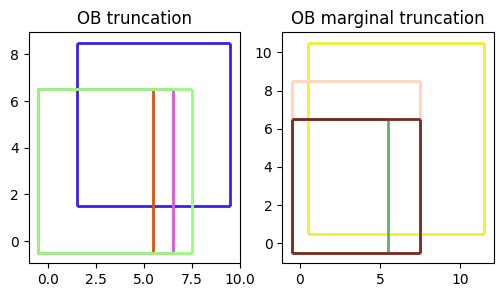

100%|██████████| 4/4 [00:20<00:00,  5.09s/it]


In [11]:
result_B = optimize_dataset_B(data)

100%|██████████| 4/4 [00:00<00:00, 49.42it/s]


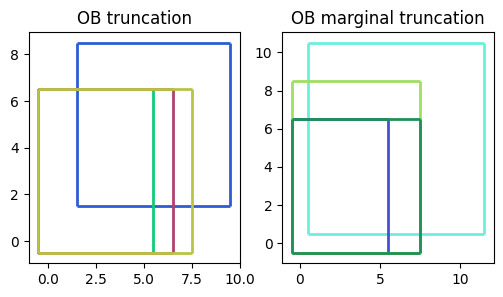

100%|██████████| 4/4 [00:21<00:00,  5.50s/it]


In [14]:
result_B_joint = optimize_dataset_B(data, joint=True)

## Results

In [10]:
result_downsampled

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE


In [15]:
result_B_joint

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,INFEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,INFEASIBLE,FEASIBLE


Without using joint probabilities & factorization in independent models:

In [16]:
result_B

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE


# 95% capture

In [34]:
data_90 = simulate_dataset(
    on_rate=0.5,
    off_rate=0.5,
    tx_rate=5,
    int_str=10,
    cells=1000,
    mean_capture=0.95
)

100%|██████████| 4/4 [00:00<00:00, 60.14it/s]


In [35]:
result_downsampled_90 = optimize_dataset_downsampled(data_90)

100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


100%|██████████| 4/4 [00:00<00:00, 55.91it/s]


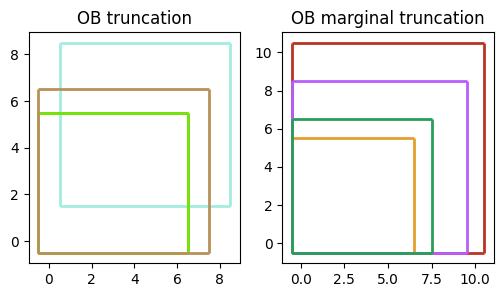

100%|██████████| 4/4 [03:33<00:00, 53.47s/it]


In [37]:
result_B_90 = optimize_dataset_B(data_90, joint_models=False)

In [29]:
result_downsampled_90

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE


In [26]:
result_B_90

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,N/A,FEASIBLE,N/A
Int. BD data,INFEASIBLE,N/A,FEASIBLE,N/A
Ind. TE data,INFEASIBLE,N/A,ERROR,N/A
Int. TE data,INFEASIBLE,N/A,FEASIBLE,N/A


# 50% capture

In [48]:
data_50 = simulate_dataset(
    on_rate=0.5,
    off_rate=0.5,
    tx_rate=5,
    int_str=10,
    cells=1000,
    mean_capture=0.5
)

100%|██████████| 4/4 [00:00<00:00, 68.06it/s]


In [49]:
result_downsampled_50 = optimize_dataset_downsampled(data_50)

100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


In [50]:
result_downsampled_50

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
